# Import các thư viện cần thiết

In [1]:
import pmdarima as pm
import pandas as pd
import numpy as np
from pmdarima import model_selection
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np
import seaborn as sns
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

# Đọc dữ liệu

In [2]:
df_train = pd.read_csv('train.csv', index_col='date')
df_test = pd.read_csv('test.csv',index_col='date')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 730 entries, 2022-01-01 to 2023-12-31
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   is_holiday       730 non-null    bool   
 1   temperature      730 non-null    float64
 2   new_total_usage  730 non-null    float64
 3   weekday_0        730 non-null    bool   
 4   weekday_1        730 non-null    bool   
 5   weekday_2        730 non-null    bool   
 6   weekday_3        730 non-null    bool   
 7   weekday_4        730 non-null    bool   
 8   weekday_5        730 non-null    bool   
 9   weekday_6        730 non-null    bool   
dtypes: bool(8), float64(2)
memory usage: 22.8+ KB


# Chia tập validate

In [4]:
df_validate = df_train.iloc[-100:, :]
df_train = df_train.iloc[:-100, :]

In [5]:
df_validate.tail()

,is_holiday,temperature,new_total_usage,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date,,,,,,,,,,
2023-12-27,False,22.45,3542.0,False,False,True,False,False,False,False
2023-12-28,False,23.40,3432.0,False,False,False,True,False,False,False
2023-12-29,False,24.00,3311.0,False,False,False,False,True,False,False
2023-12-30,False,23.62,1452.0,False,False,False,False,False,True,False
2023-12-31,False,23.55,1078.0,False,False,False,False,False,False,True


# Chuẩn bị dữ liệu để dự đoán

## Chuyển giá trị True/False về 1/0

In [6]:
def convert_columns_to_int(df, weekday_cols_prefix='weekday_', holiday_col='is_holiday', num_weekdays=6):
    """
    Chuyển đổi các cột 'weekday' và 'is_holiday' của DataFrame sang kiểu dữ liệu int.

    Tham số:
    - df: DataFrame cần chuyển đổi.
    - weekday_cols_prefix: Tiền tố của các cột 'weekday'. Mặc định là 'weekday_'.
    - holiday_col: Tên cột ngày lễ cần chuyển đổi. Mặc định là 'is_holiday'.
    - num_weekdays: Số lượng cột 'weekday' cần chuyển đổi (mặc định là 6).
    
    Trả về:
    - DataFrame với các cột đã được chuyển sang kiểu int.
    """
    
    # Chuyển đổi các cột weekday_{i} thành int
    for i in range(0, num_weekdays + 1):  # Lặp từ 1 tới num_weekdays
        df[f'{weekday_cols_prefix}{i}'] = df[f'{weekday_cols_prefix}{i}'].astype(int)
    
    # Chuyển đổi cột is_holiday thành int
    df[holiday_col] = df[holiday_col].astype(int)
    
    return df

In [7]:
df_train = convert_columns_to_int(df=df_train)
df_validate = convert_columns_to_int(df=df_validate)
df_test = convert_columns_to_int(df=df_test)

## Chuyển index về datetime

In [8]:
df_train.index = pd.to_datetime(df_train.index)
df_validate.index = pd.to_datetime(df_validate.index)
df_test.index = pd.to_datetime(df_test.index)

## Chuyển freq

In [9]:
df_train = df_train.asfreq('D')  
df_validate = df_validate.asfreq('D')  
df_test = df_test.asfreq('D')  

## Box-Cox Transformation

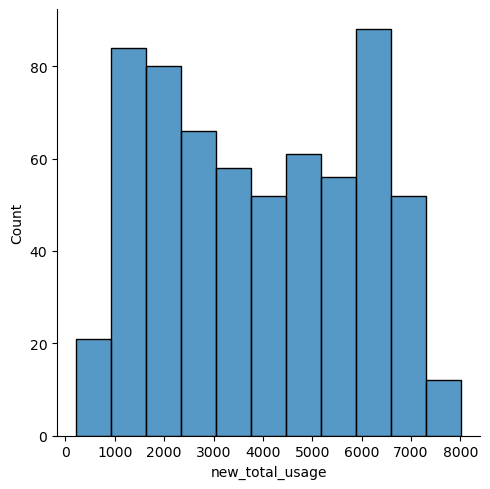

In [10]:
sns.displot(data=df_train, x='new_total_usage')

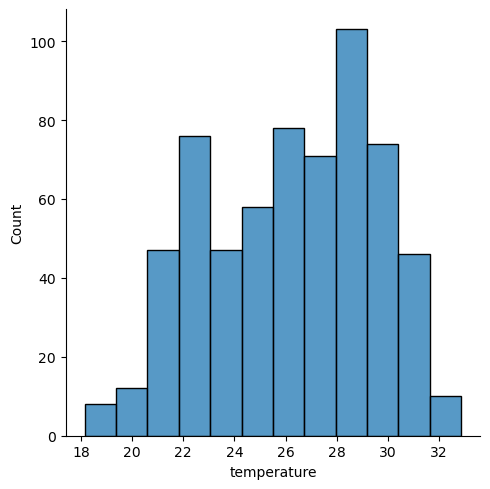

In [11]:
sns.displot(data=df_train, x='temperature')

In [12]:
df_train['new_total_usage'], lmd_usage = boxcox(df_train['new_total_usage'])
df_train['temperature'], lmd_temp = boxcox(df_train['temperature'])

In [13]:
lmd_usage

0.6337261627013608

In [14]:
lmd_temp

1.9108284846111012

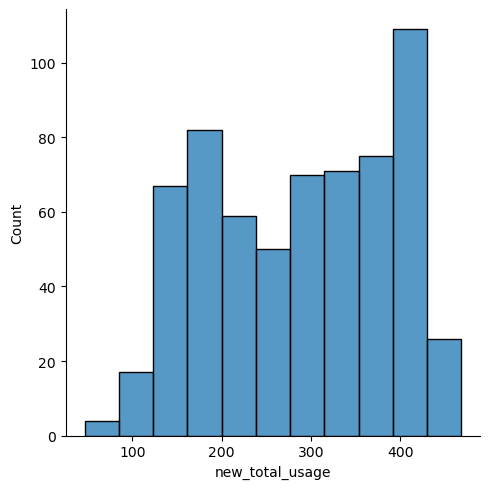

In [15]:
sns.displot(data=df_train, x='new_total_usage')

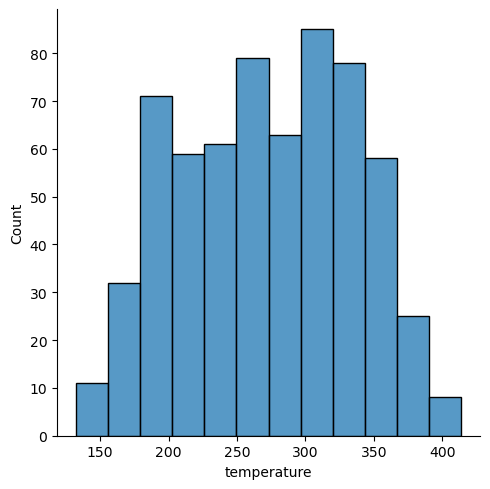

In [16]:
sns.displot(data=df_train, x='temperature')

In [17]:
df_test['new_total_usage'] = boxcox(df_test['new_total_usage'], lmd_usage)
df_test['temperature'] = boxcox(df_test['temperature'], lmd_temp)

df_validate['new_total_usage'] = boxcox(df_validate['new_total_usage'], lmd_usage)
df_validate['temperature'] = boxcox(df_validate['temperature'], lmd_temp)

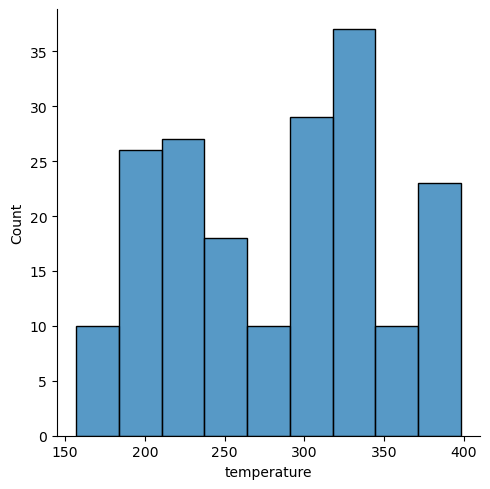

In [18]:
sns.displot(data=df_test, x='temperature')

## Chia tập X, y

In [27]:
df_validate.head()

,is_holiday,temperature,new_total_usage,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date,,,,,,,,,,
2023-09-23,0,297.678514,215.284016,0,0,0,0,0,1,0
2023-09-24,0,260.756465,152.988726,0,0,0,0,0,0,1
2023-09-25,0,297.678514,334.401866,1,0,0,0,0,0,0
2023-09-26,0,298.914876,384.407014,0,1,0,0,0,0,0
2023-09-27,0,280.025541,368.645596,0,0,1,0,0,0,0


In [ ]:
df_train.drop(['new_total_usage'], axis='columns')

In [21]:
X_train = df_train.drop(['new_total_usage'], axis='columns')
y_train = df_train.loc[:,'new_total_usage']
X_validate = df_validate.drop(['new_total_usage'], axis='columns')
y_validate = df_validate.loc[:,'new_total_usage']
X_test = df_test.drop(['new_total_usage'], axis='columns')
y_test = df_test.loc[:,'new_total_usage']


In [22]:
X_train.shape

(630, 9)

In [23]:
y_train.shape

(630,)

In [24]:
X_test.shape

(190, 9)

In [25]:
y_test.shape

(190,)

In [28]:
y_train

date
2022-01-01    160.653679
2022-01-02    137.779339
2022-01-03    158.376547
2022-01-04    302.757197
2022-01-05    310.063925
                 ...    
2023-09-18    391.243145
2023-09-19    398.908592
2023-09-20    406.490158
2023-09-21    398.011195
2023-09-22    394.409887
Freq: D, Name: new_total_usage, Length: 630, dtype: float64

# Seasonal components

In [ ]:
df_train.info()

In [16]:
ts_decomposition = seasonal_decompose(x=df_train['new_total_usage'], model='additive')
trend_estimate = ts_decomposition.trend
seasonal_estimate = ts_decomposition.seasonal
residual_estimate = ts_decomposition.resid

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(df_train['new_total_usage'], label='Original')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(trend_estimate, label='Trend')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(seasonal_estimate, label='Seasonal')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(residual_estimate, label='Residual')
plt.legend()

In [ ]:
plt.figure(figsize=(35,10))
plt.grid()
plt.plot(df_train['new_total_usage'], marker='o', label='Original')
plt.plot(df_train['new_total_usage'].rolling(window=30).mean(), marker='o', label='Rolling Mean')
plt.plot(df_train['new_total_usage'].rolling(window=30).std(), marker='o', label='Rolling Std')
plt.xticks(rotation=90)
plt.legend()
plt.show()

# Kiểm tra tính stationary:
- Time series được coi là stationary khi constant mean, constant variance và constant autocorrelation

In [19]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, signif=0.05, name='', verbose=False):
    

    result = adfuller(series.values)
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [ ]:
for name, column in df_train.items():
    check_stationarity(column, name=column.name)
    print('\n')

## Nhận xét:
- Trừ new_total_usage và temperature thì các feature còn lại đều là stationary

# Fit model

In [29]:
X_train.head()

,is_holiday,temperature,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date,,,,,,,,,
2022-01-01,1,189.916622,0,0,0,0,0,1,0
2022-01-02,0,191.081993,0,0,0,0,0,0,1
2022-01-03,1,191.582474,1,0,0,0,0,0,0
2022-01-04,0,201.380680,0,1,0,0,0,0,0
2022-01-05,0,208.273302,0,0,1,0,0,0,0


In [30]:
arima = pm.auto_arima(y_train,X=X_train,m=31, seasonal=False, trace=2,d=None,start_p=0, start_q=0,  max_p=12, max_q=12,   D=None,        
                    stationary=True,test='adf', error_action='trace')

c:\Users\ASUS\.conda\envs\time_series_env\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (31) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=6947.660, Time=0.30 sec
First viable model found (6947.660)
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=6944.133, Time=0.22 sec
New best model found (6944.133 < 6947.660)
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=6942.204, Time=0.20 sec
New best model found (6942.204 < 6944.133)
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6945.660, Time=0.52 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=6892.239, Time=0.65 sec
New best model found (6892.239 < 6942.204)
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=6877.977, Time=0.76 sec
New best model found (6877.977 < 6892.239)
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=6943.226, Time=0.16 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=6742.722, Time=1.22 sec
New best model found (6742.722 < 6877.977)
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=6751.187, Time=0.56 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=6743.963, Time=1.31 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=6713

In [31]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  630
Model:              SARIMAX(11, 0, 7)   Log Likelihood               -3269.765
Date:                Wed, 11 Sep 2024   AIC                           6595.531
Time:                        16:06:14   BIC                           6720.011
Sample:                    01-01-2022   HQIC                          6643.882
                         - 09-22-2023                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
is_holiday   -109.0299      6.350    -17.171      0.000    -121.475     -96.585
temperature     0.5002      0.075      6.693      0.000       0.354       0.647
weekday_0     196.6206     25.210      7.799      0.000     147.209     246.032
weekday_1     195.9951     25.702      7.626      0.000     145.621     246.369
weekday_2     186.3130     26.428      7.050      0.000     134.515     238.111
weekday_3     186.8644     27.119      6.890      0.000     133.711     240.017
weekday_4     187.3017     26.402      7.094      0.000     135.554     239.049
weekday_5      69.9719     26.417      2.649      0.008      18.196     121.748
weekday_6      15.9025     26.154      0.608      0.543     -35.358      67.163
ar.L1           0.0087      0.228      0.038      0.970      -0.437       0.455
ar.L2           0.0906      0.116      0.782      0.434      -0.136       0.317
ar.L3           0.2139      0.089      2.397      0.017       0.039       0.389
ar.L4          -0.0056      0.092     -0.061      0.952      -0.186       0.175
ar.L5          -0.4365      0.072     -6.032      0.000      -0.578      -0.295
ar.L6           0.6961      0.077      9.083      0.000       0.546       0.846
ar.L7           0.3166      0.177      1.792      0.073      -0.030       0.663
ar.L8           0.1714      0.056      3.057      0.002       0.061       0.281
ar.L9          -0.0022      0.061     -0.036      0.972      -0.121       0.117
ar.L10         -0.2537      0.061     -4.165      0.000      -0.373      -0.134
ar.L11          0.1346      0.072      1.877      0.061      -0.006       0.275
ma.L1           0.1374      0.225      0.610      0.542      -0.304       0.579
ma.L2          -0.2566      0.099     -2.598      0.009      -0.450      -0.063
ma.L3           0.0437      0.112      0.390      0.696      -0.176       0.263
ma.L4           0.0519      0.069      0.754      0.451      -0.083       0.187
ma.L5           0.3145      0.072      4.386      0.000       0.174       0.455
ma.L6          -0.4546      0.069     -6.607      0.000      -0.589      -0.320
ma.L7          -0.3252      0.139     -2.344      0.019      -0.597      -0.053
sigma2       1929.2879     82.863     23.283      0.000    1766.879    2091.697
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               427.96
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               3.33   Skew:                            -0.81
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
arima.params

In [32]:
pred=arima.predict(n_periods=100, X=X_validate, alpha=0.05)
pred

2023-09-23    230.804171
2023-09-24    158.559412
2023-09-25    365.378591
2023-09-26    390.271826
2023-09-27    376.198780
                 ...    
2023-12-27    298.957002
2023-12-28    305.953012
2023-12-29    309.935252
2023-12-30    186.739574
2023-12-31    131.000542
Freq: D, Length: 100, dtype: float64

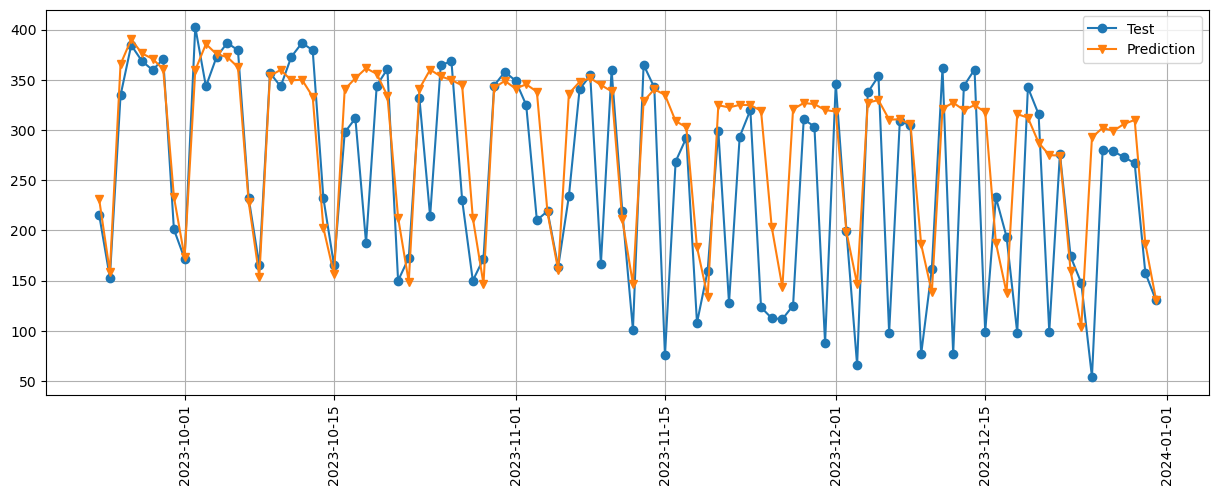

In [33]:
plt.figure(figsize=(15,5))
plt.grid()
#plt.plot(data['Period'][:-10], train['GDP_GROWTH'], marker='o', label='Train')
plt.plot(df_validate.index,y_validate, marker='o', label='Test')
plt.plot(df_validate.index,pred, marker='v', label='Prediction')
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [34]:
mape=mean_absolute_percentage_error(y_validate, pred)
print("Mean Absolute Percentage Error", mape)


Mean Absolute Percentage Error 0.42294960592909425


In [35]:
mse=mean_squared_error(y_validate, pred)
print("Mean Squared Error",mse)

Mean Squared Error 7378.224087627599


In [36]:
print("RMSE", (mse)**0.5)

RMSE 85.89658949939513


In [37]:
print("AIC values {}".format(arima.aic()))

AIC values 6595.530925945915


# ARIMA

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

# decompose the time series into its trend, seasonal and residuals components
result_decompose = seasonal_decompose(df_train['new_total_usage'], model='additive')


In [ ]:
df_train.info()

In [ ]:
trend     = result_decompose.trend
seasonal  = result_decompose.seasonal
residuals = result_decompose.resid
# plot every component
plt.figure(figsize=(20,10))
plt.subplot(311)
plt.plot(trend)
plt.title('trend')
plt.subplot(312)
plt.plot(seasonal)
plt.title('seasonality')
plt.subplot(313)
plt.plot(residuals)
plt.title('residuals')